<a href="https://colab.research.google.com/github/nilanahar/MMAI_894_DeepLearning_Project_TeamRosedale/blob/main/MMAI_894_Team_Project_ResNet%2BGoogleWord2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up Environment

#### Packages to Load

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import json
import joblib
import os
import re
import ast
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# from wordcloud import WordCloud
# from collections import Counter

# import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

!pip install optuna
import optuna

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# define my google drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


#### Functions to Use (Must Run)

In [3]:
# Function to load multiple JSON data
def load_json(file_path):
    if file_path: # Check if file_path is not None
        with open(file_path, 'r') as f:
            return json.load(f)
    else:
        return None # or handle the None case differently, like returning an empty dictionary

def json_to_pdDf(mcq_file_path, oeq_file_path, answers_file_path):
    # Now you can use this function to load multiple JSON files
    mcq_json_data = load_json(mcq_file_path)
    oeq_json_data = load_json(oeq_file_path)

    mcq_df = pd.json_normalize(mcq_json_data['questions'])[['image_id', 'question_id', 'question', 'multiple_choices']]
    oeq_df = pd.json_normalize(oeq_json_data['questions'])[['image_id', 'question_id', 'question']]

    # Check if answers_file_path is None
    if answers_file_path is not None:
        answers_json_data = load_json(answers_file_path)
        answers_df = pd.json_normalize(answers_json_data['annotations'])[['image_id', 'question_id', 'question_type', 'answers', 'multiple_choice_answer', 'answer_type']]
    else:
        # Create an empty DataFrame if answers_file_path is None
        answers_df = pd.DataFrame(columns=['image_id', 'question_id', 'question_type', 'answers', 'multiple_choice_answer', 'answer_type'])

    return mcq_df, oeq_df, answers_df


def tabularize_answers_df(answers_df):
    # Create a unique identifier for each row to track back after transformations
    answers_df['index'] = answers_df.index
    # Explode the 'answers' column into separate rows, while keeping other columns intact
    answers_expanded_df = answers_df.explode('answers')
    # normalization as before
    answers_details = pd.json_normalize(answers_expanded_df['answers'])
    answers_details['index'] = answers_expanded_df.index
    # Concatenate back to the actual answers DataFrame
    answers_expanded_df = pd.merge(answers_df, answers_details, on='index', how='left')
    answers_merged_df = answers_expanded_df[['image_id', 'question_id', 'question_type',
                                              'multiple_choice_answer', 'answer_type',
                                              'answer', 'answer_id', 'answer_confidence',
                                              'index']]
    answers_merged_df = answers_merged_df.rename(columns={'multiple_choice_answer': 'target_answer'})

    return answers_merged_df

# Function to extract features from multiple JSON files
def extract_qna_features(mcq_file_path, oeq_file_path, answers_file_path):

    mcq_df, oeq_df, answers_df = json_to_pdDf(mcq_file_path, oeq_file_path, answers_file_path)

    # answers_merged_df = tabularize_answers_df(answers_df)
    answers_merged_df = answers_df

    questions_merged_df = pd.merge(mcq_df, oeq_df, on=['image_id', 'question_id'], how='left', suffixes=('_oeq', '_mcq'))
    final_qna_df = pd.merge(questions_merged_df, answers_merged_df, on=['image_id', 'question_id'], how='left')

    return mcq_df, oeq_df, answers_merged_df, final_qna_df


# Function to extract last five digits from file names
def extract_last_five_digits(filename):
    match = re.search(r'(\d{5})\.png$', filename)
    if match:
        return match.group(1)
    else:
        raise ValueError(f"Filename {filename} does not match the expected pattern.")

def extract_image_features(model, images_file_path):
    images_features_dict = {}
    for img_name in tqdm(os.listdir(images_file_path)):
        img_path = os.path.join(images_file_path, img_name)

        # Extract image_id (adjust slice according to your filename structure)
        image_id = img_name[-9:-4]  # Example: extracting last 5 digits before file extension

        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(224, 224))
        x = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))

        # Extract features and store them in the dictionary
        features = model.predict(x)
        images_features_dict[image_id] = features.flatten()

    images_features_df = pd.DataFrame.from_dict(images_features_dict, orient='index')
    images_features_df.reset_index(inplace=True)
    images_features_df.rename(columns={'index': 'image_id'}, inplace=True)

    return images_features_df


def complete_datasets(qna_df, images_features_df):
    qna_df = qna_df.sort_values(by='image_id').reset_index(drop=True)
    images_features_df = images_features_df.sort_values(by='image_id').reset_index(drop=True)
    images_features_df['image_id'] = images_features_df['image_id'].astype(int)
    # Merge the 3 dataframes into one (base dataset is image_df (unique), left join qna on image id)
    complete_training_set = pd.merge(images_features_df, qna_df, on='image_id', how='left')
    return complete_training_set

def preprocess_text(text):
    """
    Improved text preprocessing function that retains context and meaning.
    - Converts text to lowercase.
    - Removes non-alphabetic characters.
    - Tokenizes, removes only non-essential stopwords, and lemmatizes.
    """
    if pd.isnull(text):
        return ''

    # Convert text to lowercase
    text = text.lower()
    # Remove non-alphabetic characters (but keep question marks and spaces)
    text = re.sub(r'[^a-z\s\?]', '', text)
    # Tokenize text into words
    words = text.split()
    # Create a lemmatizer object
    lemmatizer = WordNetLemmatizer()
    # Define stop words
    stop_words = set(stopwords.words('english')) # Define stop_words here
    essential_stopwords = {"how", "how many", "what", "when", "why", "which", "where", "who"}
    # Remove stopwords, but retain essential question words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words or word in essential_stopwords]
    # Join words back into a single string
    return ' '.join(words)


def get_sentence_embedding(sentence, model):
    """
    Calculates the sentence embedding by averaging the word embeddings of all words in the sentence.
    If a word is not found in the model, it's embedding is considered as a zero vector.
    """
    # Convert series to string
    if isinstance(sentence, pd.Series):
        sentence = ' '.join(sentence.astype(str).tolist())
    words = sentence.split()
    # Removed .wv since model is already a KeyedVectors object
    word_vectors = [model[word] for word in words if word in model]

    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)

    return np.mean(word_vectors, axis=0)


# Modified filter_choices_by_cosine_similarity function using Word2Vec
def filter_choices_by_word2vec_similarity(row, model):
    """
    Filters multiple-choice options based on their cosine similarity with the question using Word2Vec embeddings.
    Args:
    - row: A DataFrame row containing a 'question' and 'multiple_choices' columns.
    - model: Trained Word2Vec model.

    Returns:
    - A list of filtered multiple-choice options based on cosine similarity.
    """
    question = row['question']
    choices = row['multiple_choices']  # Assume 'multiple_choices' column has a list of answer options

    # Step 1: Generate Word2Vec embeddings for the question
    question_embedding = get_sentence_embedding(question, model)

    # Step 2: Generate Word2Vec embeddings for each choice
    choice_embeddings = [get_sentence_embedding(choice, model) for choice in choices]

    # Step 3: Calculate cosine similarity between question embedding and each choice embedding
    similarity_scores = cosine_similarity([question_embedding], choice_embeddings)[0]

    # Step 4: Retain choices with a high similarity score (e.g., > 0.3)
    threshold = 0.3
    filtered_choices = [choices[i] for i, score in enumerate(similarity_scores) if score >= threshold]

    # Step 5: If no choices pass the threshold, keep original choices to avoid empty options
    return filtered_choices if filtered_choices else choices

# Step 1: Concatenate List into a Single Sentence for Each Row
def concatenate_list_to_sentence(row, list_column):
    """
    Concatenate all words in a list (in a single row) into a single string.
    Args:
    - row: A single row of the DataFrame.
    - list_column: Column name containing lists of words.

    Returns:
    - A single concatenated string of all words in the list.
    """
    return " ".join(row[list_column])  # Join words with a space separator


#### Define Constants

In [4]:
id_features = ['image_id', 'question_id', 'question_length']

categorical_features = [  'question', 'question_clean', 'question_type',
                          'multiple_choices',  'filtered_multiple_choices', 'filtered_multiple_choice_corpus',
                          ]

# numerical_features = [col for col in X_train.columns if col not in categorical_features + id_features]

In [21]:
# model = ResNet50(weights='imagenet', include_top=False)
# wxord2vec_model = api.load('word2vec-google-news-300')
# joblib.dump(word2vec_model, "/content/drive/MyDrive/Colab Notebooks/894/Training/(2)_word2vec_model_for_2.2.joblib")
model = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/Google_Word2Vec_FeatureExtraction_Model.joblib")

# Step 1: Data Collection & Feature Extraction

#### Set Directories

In [17]:
# Define the file path (adjust it to match your folder structure)
training_mcq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Training/Data/MultipleChoice_abstract_v002_train2015_questions.json"
training_oeq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Training/Data/OpenEnded_abstract_v002_train2015_questions.json"
training_answers_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Training/Data/abstract_v002_train2015_annotations.json"
training_images_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Training/Data/scene_img_abstract_v002_train2015"

validation_mcq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Validation/Data/MultipleChoice_abstract_v002_val2015_questions.json"
validation_oeq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Validation/Data/OpenEnded_abstract_v002_val2015_questions.json"
validation_answers_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Validation/Data/abstract_v002_val2015_annotations.json"
validation_images_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Validation/Data/scene_img_abstract_v002_val2015"

testing_mcq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Testing/Data/MultipleChoice_abstract_v002_test2015_questions.json"
testing_oeq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Testing/Data/OpenEnded_abstract_v002_test2015_questions.json"
testing_images_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Testing/Data/scene_img_abstract_v002_test2015"

### 1.1 Training Datasets

#### 1.1.1 Extracting Questions & Answers & Features

In [18]:
train_mcq_df, train_oeq_df, train_answers_merged_df, train_final_qna_df = extract_qna_features(training_mcq_file_path, training_oeq_file_path, training_answers_file_path)
train_final_qna_df.head(5)

,image_id,question_id,question_oeq,multiple_choices,question_mcq,question_type,answers,multiple_choice_answer,answer_type
0,11779,117792,Who looks happier?,"[alive, 1, woman, purple, 2, yes, white, boy, ...",Who looks happier?,who,"[{'answer': 'old person', 'answer_confidence':...",man,other
1,11779,117790,Where is the woman sitting?,"[3, no, blue, red, 1, slide, monkey bars, jump...",Where is the woman sitting?,where is the,"[{'answer': 'on blanket', 'answer_confidence':...",blanket,other
2,11779,117791,Where is the man sitting?,"[away, yes, blue, 1, 2, mouse, couch, no, yell...",Where is the man sitting?,where is the,"[{'answer': 'on bench', 'answer_confidence': '...",bench,other
3,5536,55360,Is this man hungry?,"[water, yellow, 4, running, blue, pouring, out...",Is this man hungry?,is this,"[{'answer': 'yes', 'answer_confidence': 'yes',...",yes,yes/no
4,5536,55361,What kind of drink is that?,"[wine, girl would fall, soda, white, yes, coke...",What kind of drink is that?,what kind of,"[{'answer': 'water', 'answer_confidence': 'no'...",soda,other


##### Save Workspace

In [19]:
# Save the dataframes to Google Drive
joblib.dump(train_final_qna_df, "/content/drive/MyDrive/Colab Notebooks/894/Training/questions_answers_features.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/Training/questions_answers_features.joblib']

#### 1.1.2 Extracting Images' Features


In [ ]:
train_images_features_df = extract_image_features(model, training_images_file_path)

##### Save Workspace

In [ ]:
joblib.dump(train_images_features_df, "/content/drive/MyDrive/Colab Notebooks/894/Training/images_features.joblib")

#### 1.1.3 Complete Training Dataset

##### Load Workspace

In [34]:
train_qna_df = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/questions_answers_features.joblib")
train_images_df = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/images_features.joblib")
train_images_df.shape

(20000, 2049)

In [35]:
train_complete_df = complete_datasets(train_qna_df, train_images_df)
train_complete_df.head()

,image_id,0,1,2,3,4,5,6,7,8,...,2046,2047,question_id,question_oeq,multiple_choices,question_mcq,question_type,answers,multiple_choice_answer,answer_type
0,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,1.623500,0.379023,2,Is the bench a toy?,"[1, csi, real, n, red, solid, blocks and car, ...",Is the bench a toy?,is the,"[{'answer': 'no', 'answer_confidence': 'yes', ...",no,yes/no
1,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,1.623500,0.379023,1,How is the equipments with bars called?,"[get warm, yes, playful, pug, red, fitness sys...",How is the equipments with bars called?,how,"[{'answer': 'monkey bars', 'answer_confidence'...",monkey bars,other
2,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,1.623500,0.379023,0,What color is the ladies pants?,"[1, 3, brown, wildlife, not having tv, yellow,...",What color is the ladies pants?,what color is the,"[{'answer': 'tan', 'answer_confidence': 'yes',...",tan,other
3,1,0.295177,0.688931,0.079504,0.947996,0.140809,0.325638,0.344328,1.227646,0.559828,...,1.609317,0.766711,11,What is the woman doing?,"[4, yellow, no, 2, reading, holding table, bar...",What is the woman doing?,what is the woman,"[{'answer': 'sitting', 'answer_confidence': 'y...",sitting,other
4,1,0.295177,0.688931,0.079504,0.947996,0.140809,0.325638,0.344328,1.227646,0.559828,...,1.609317,0.766711,10,Is the woman on the couch sporting white hair?,"[1, 3, idk, no, 2, red, skinny, blue, yes, hin...",Is the woman on the couch sporting white hair?,is the woman,"[{'answer': 'yes', 'answer_confidence': 'yes',...",yes,yes/no


##### Save Workspace

In [36]:
joblib.dump(train_complete_df, "/content/drive/MyDrive/Colab Notebooks/894/Training/complete_training_set_tabular.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/Training/complete_training_set_tabular.joblib']

### 1.2 Validation Datasets

#### 1.2.1 Extracting Questions & Answers


In [37]:
valid_mcq_df, valid_oeq_df, valid_answers_merged_df, valid_final_qna_df = extract_qna_features(validation_mcq_file_path, validation_oeq_file_path, validation_answers_file_path)
valid_final_qna_df.head()

,image_id,question_id,question_oeq,multiple_choices,question_mcq,question_type,answers,multiple_choice_answer,answer_type
0,27578,275780,Is the dog asleep?,"[white, picnicking, yes, hot, dog and girl, bl...",Is the dog asleep?,is the dog,"[{'answer': 'yes', 'answer_confidence': 'yes',...",yes,yes/no
1,27578,275781,What is the man looking at?,"[monkey bars, drinking, dog, red, blue, son, b...",What is the man looking at?,what is the man,"[{'answer': 'tv', 'answer_confidence': 'yes', ...",tv,other
2,27578,275782,Is the man sitting on the armrest?,"[2, brown, wider, sitting, yes, marriage, red,...",Is the man sitting on the armrest?,is the man,"[{'answer': 'yes', 'answer_confidence': 'yes',...",yes,yes/no
3,21768,217680,Did she bake the pie?,"[golden girls, sky, 1, blue, 2, 4, no, feeding...",Did she bake the pie?,none of the above,"[{'answer': 'yes', 'answer_confidence': 'yes',...",yes,yes/no
4,21768,217681,What is resting on the table besides the pie?,"[brown, air, cumulus, no, it is playing, wine ...",What is resting on the table besides the pie?,what is,"[{'answer': 'wine glass', 'answer_confidence':...",wine glass,other


##### Save Workspace

In [24]:
joblib.dump(valid_final_qna_df, "/content/drive/MyDrive/Colab Notebooks/894/Validation/questions_answers_features.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/Validation/questions_answers_features.joblib']

#### 1.2.2 Extracting Images' Features

In [ ]:
valid_images_features_df = extract_image_features(model, validation_images_file_path)

In [ ]:
valid_images_features_df.shape

##### Save Workspace

In [ ]:
joblib.dump(valid_images_features_df, "/content/drive/MyDrive/Colab Notebooks/894/Validation/images_features.joblib")

#### 1.2.3  Complete Validation Dataset

##### Load Workspace

In [38]:
dfValid = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/(2)_dfValid_w2v_2.2.joblib")
dfValid.head()

,image_id,0,1,2,3,4,5,6,7,8,...,question_length,question_clean,question_embedding,answer_clean,answer_embedding,filtered_multiple_choices,filtered_multiple_choice_corpus,filtered_choices_embedding,answer_type_encoded,answer_confidence_encoded
0,20000,0.874148,0.477496,0.066509,0.95172,0.075566,2.393809,1.363019,0.398546,2.833386,...,5,window appear dirty?,"[0.020385742, 0.08544922, -0.1706543, 0.012451...",,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[above fireplace, behind roof, windows do not ...",above fireplace behind roof windows do not match,"[0.051086426, -0.021697998, 0.0071258545, 0.02...",2,2
1,20000,0.874148,0.477496,0.066509,0.95172,0.075566,2.393809,1.363019,0.398546,2.833386,...,5,window appear dirty?,"[0.020385742, 0.08544922, -0.1706543, 0.012451...",,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[above fireplace, behind roof, windows do not ...",above fireplace behind roof windows do not match,"[0.051086426, -0.021697998, 0.0071258545, 0.02...",2,2
2,20000,0.874148,0.477496,0.066509,0.95172,0.075566,2.393809,1.363019,0.398546,2.833386,...,5,window appear dirty?,"[0.020385742, 0.08544922, -0.1706543, 0.012451...",,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[above fireplace, behind roof, windows do not ...",above fireplace behind roof windows do not match,"[0.051086426, -0.021697998, 0.0071258545, 0.02...",2,2
3,20000,0.874148,0.477496,0.066509,0.95172,0.075566,2.393809,1.363019,0.398546,2.833386,...,4,curtain match?,"[0.22167969, 0.14648438, 0.1484375, -0.2353515...",yes,"[0.115722656, -0.12988281, 0.06591797, 0.17578...","[white with flowers, windows do not match]",white with flowers windows do not match,"[0.038783483, 0.032087054, 0.055228096, 0.1036...",2,2
4,20000,0.874148,0.477496,0.066509,0.95172,0.075566,2.393809,1.363019,0.398546,2.833386,...,5,window appear dirty?,"[0.020385742, 0.08544922, -0.1706543, 0.012451...",,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[above fireplace, behind roof, windows do not ...",above fireplace behind roof windows do not match,"[0.051086426, -0.021697998, 0.0071258545, 0.02...",2,2


In [42]:
valid_images_df = dfValid.iloc[:, :2049]
valid_images_df = valid_images_df.drop_duplicates()
valid_images_df.shape

(10000, 2049)

In [43]:
valid_qna_df = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/questions_answers_features.joblib")
# valid_images_df = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/images_features.joblib")
valid_images_df.shape

(10000, 2049)

In [44]:
valid_complete_df = complete_datasets(valid_qna_df, valid_images_df)
valid_complete_df.head()

,image_id,0,1,2,3,4,5,6,7,8,...,2046,2047,question_id,question_oeq,multiple_choices,question_mcq,question_type,answers,multiple_choice_answer,answer_type
0,20000,0.874148,0.477496,0.066509,0.951720,0.075566,2.393809,1.363019,0.398546,2.833386,...,2.552034,0.495182,200001,Do the windows appear dirty?,"[4, 3, above fireplace, brown, yes, 1, no, beh...",Do the windows appear dirty?,do the,"[{'answer': 'no', 'answer_confidence': 'yes', ...",no,yes/no
1,20000,0.874148,0.477496,0.066509,0.951720,0.075566,2.393809,1.363019,0.398546,2.833386,...,2.552034,0.495182,200000,What color is the fire?,"[white, red, yellow, red and orange, red orang...",What color is the fire?,what color is the,"[{'answer': 'orange', 'answer_confidence': 'ye...",orange,other
2,20000,0.874148,0.477496,0.066509,0.951720,0.075566,2.393809,1.363019,0.398546,2.833386,...,2.552034,0.495182,200002,Do the curtains match?,"[smiling, 4, for fun, no, forest, 3, sandwich ...",Do the curtains match?,do the,"[{'answer': 'yes', 'answer_confidence': 'yes',...",yes,yes/no
3,20001,0.217491,0.800554,0.645356,0.052699,0.000000,0.590569,0.242906,0.040872,0.199172,...,0.379245,0.395195,200010,Does the sidewalk suddenly disappear?,"[no, brown, white, 4, no i think it looks more...",Does the sidewalk suddenly disappear?,does the,"[{'answer': 'yes', 'answer_confidence': 'yes',...",yes,yes/no
4,20001,0.217491,0.800554,0.645356,0.052699,0.000000,0.590569,0.242906,0.040872,0.199172,...,0.379245,0.395195,200011,Where are the squirrel?,"[2, off, 3, red, 1, yes, under tree, white, no...",Where are the squirrel?,where are the,"[{'answer': 'under tree', 'answer_confidence':...",under tree,other


##### Save Workspace

In [45]:
joblib.dump(valid_complete_df, "/content/drive/MyDrive/Colab Notebooks/894/Validation/complete_validation_set_tabular.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/Validation/complete_validation_set_tabular.joblib']

# Step 2: Exploratory Data Analysis & Feature Engineering

##### Load Workspace

In [46]:
df_train = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/complete_training_set_tabular.joblib")
df_valid = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/complete_validation_set_tabular.joblib")
df_train.head()

,image_id,0,1,2,3,4,5,6,7,8,...,2046,2047,question_id,question_oeq,multiple_choices,question_mcq,question_type,answers,multiple_choice_answer,answer_type
0,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,1.623500,0.379023,2,Is the bench a toy?,"[1, csi, real, n, red, solid, blocks and car, ...",Is the bench a toy?,is the,"[{'answer': 'no', 'answer_confidence': 'yes', ...",no,yes/no
1,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,1.623500,0.379023,1,How is the equipments with bars called?,"[get warm, yes, playful, pug, red, fitness sys...",How is the equipments with bars called?,how,"[{'answer': 'monkey bars', 'answer_confidence'...",monkey bars,other
2,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,1.623500,0.379023,0,What color is the ladies pants?,"[1, 3, brown, wildlife, not having tv, yellow,...",What color is the ladies pants?,what color is the,"[{'answer': 'tan', 'answer_confidence': 'yes',...",tan,other
3,1,0.295177,0.688931,0.079504,0.947996,0.140809,0.325638,0.344328,1.227646,0.559828,...,1.609317,0.766711,11,What is the woman doing?,"[4, yellow, no, 2, reading, holding table, bar...",What is the woman doing?,what is the woman,"[{'answer': 'sitting', 'answer_confidence': 'y...",sitting,other
4,1,0.295177,0.688931,0.079504,0.947996,0.140809,0.325638,0.344328,1.227646,0.559828,...,1.609317,0.766711,10,Is the woman on the couch sporting white hair?,"[1, 3, idk, no, 2, red, skinny, blue, yes, hin...",Is the woman on the couch sporting white hair?,is the woman,"[{'answer': 'yes', 'answer_confidence': 'yes',...",yes,yes/no


### 2.1 Visualization & Insights

##### Keeping only one question column since question_oeq = question_mcq

In [47]:
# Check if two specific columns are identical in the DataFrame
are_questions_columns_equal = df_train['question_oeq'].equals(df_train['question_mcq'])  # Replace 'question_x' and 'question_y' with your actual column names

# Print the result
print("Are 'question_oeq' and 'question_mcq' identical? : ", "Yes" if are_questions_columns_equal else "No")

Are 'question_oeq' and 'question_mcq' identical? :  Yes


In [48]:
df_train['question'] = df_train['question_oeq']
df_valid['question'] = df_valid['question_oeq']

df_train = df_train.drop(columns=['question_oeq', 'question_mcq'])
df_valid = df_valid.drop(columns=['question_oeq', 'question_mcq'])

##### Questions' Length Visualization

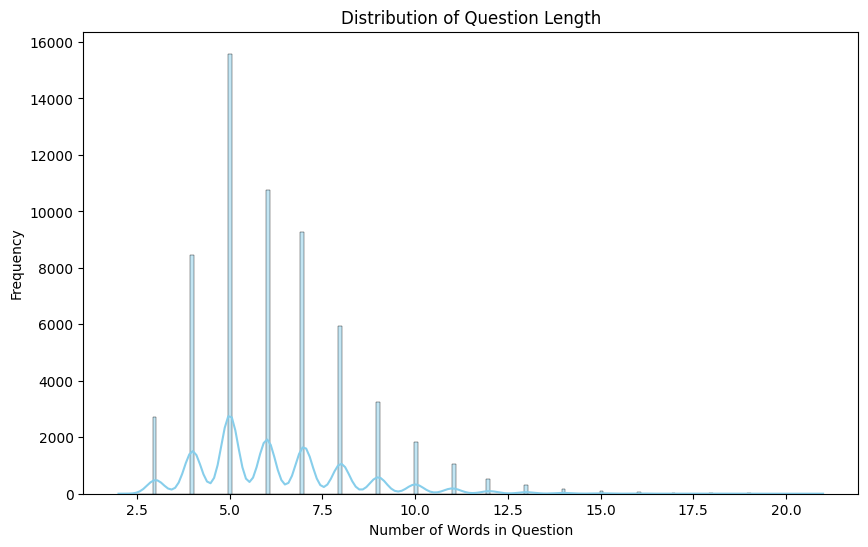

In [49]:
# Analyze Question Length
df_train['question_length'] = df_train['question'].apply(lambda x: len(x.split()))
df_valid['question_length'] = df_valid['question'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df_train['question_length'], kde=True, color='skyblue')
plt.title('Distribution of Question Length')
plt.xlabel('Number of Words in Question')
plt.ylabel('Frequency')
plt.show()

##### Questions' Common Words

In [ ]:
# # Most common words in question
# question_text = df_train['question']
# question_words = question_text.split()
# word_counts = Counter(question_words)
# common_words = word_counts.most_common(20)
# print("\nMost Common Words in Questions:")
# for word, count in common_words:
#     print(f"{word}: {count}")

##### Save Workspace

In [50]:
joblib.dump(df_train, "/content/drive/MyDrive/Colab Notebooks/894/Training/(1)_dfTrain_unique_2.1.joblib")
joblib.dump(df_valid, "/content/drive/MyDrive/Colab Notebooks/894/Validation/(1)_dfValid_unique_2.1.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/Validation/(1)_dfValid_unique_2.1.joblib']

### 2.2 Embeddings/Encodings

##### Load Workspace

In [23]:
df_train = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/(1)_dfTrain_unique_2.1.joblib")
df_valid = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/(1)_dfValid_unique_2.1.joblib")
df_train.head()

,image_id,0,1,2,3,4,5,6,7,8,...,2046,2047,question_id,multiple_choices,question_type,answers,multiple_choice_answer,answer_type,question,question_length
0,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,1.623500,0.379023,2,"[1, csi, real, n, red, solid, blocks and car, ...",is the,"[{'answer': 'no', 'answer_confidence': 'yes', ...",no,yes/no,Is the bench a toy?,5
1,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,1.623500,0.379023,1,"[get warm, yes, playful, pug, red, fitness sys...",how,"[{'answer': 'monkey bars', 'answer_confidence'...",monkey bars,other,How is the equipments with bars called?,7
2,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,1.623500,0.379023,0,"[1, 3, brown, wildlife, not having tv, yellow,...",what color is the,"[{'answer': 'tan', 'answer_confidence': 'yes',...",tan,other,What color is the ladies pants?,6
3,1,0.295177,0.688931,0.079504,0.947996,0.140809,0.325638,0.344328,1.227646,0.559828,...,1.609317,0.766711,11,"[4, yellow, no, 2, reading, holding table, bar...",what is the woman,"[{'answer': 'sitting', 'answer_confidence': 'y...",sitting,other,What is the woman doing?,5
4,1,0.295177,0.688931,0.079504,0.947996,0.140809,0.325638,0.344328,1.227646,0.559828,...,1.609317,0.766711,10,"[1, 3, idk, no, 2, red, skinny, blue, yes, hin...",is the woman,"[{'answer': 'yes', 'answer_confidence': 'yes',...",yes,yes/no,Is the woman on the couch sporting white hair?,9


##### 2.2.1 Questions Text's Features' Engineering

In [24]:
df_train['question_clean'] = df_train['question'].apply(preprocess_text)
df_valid['question_clean'] = df_valid['question'].apply(preprocess_text)
df_train[['question', 'question_clean']]

,question,question_clean
0,Is the bench a toy?,bench toy?
1,How is the equipments with bars called?,how equipment bar called?
2,What color is the ladies pants?,what color lady pants?
3,What is the woman doing?,what woman doing?
4,Is the woman on the couch sporting white hair?,woman couch sporting white hair?
...,...,...
59995,What is on fire?,what fire?
59996,Where is the fire?,where fire?
59997,Do you see a pillow?,see pillow?
59998,Why does the boy have his hand on his head?,why boy hand head?


In [25]:
# Apply the get_sentence_embedding function to each row of the 'question_clean' column
df_train['question_embedding'] = df_train['question_clean'].apply(lambda x: get_sentence_embedding(x, model))
df_valid['question_embedding'] = df_valid['question_clean'].apply(lambda x: get_sentence_embedding(x, model))
df_train.head()

,image_id,0,1,2,3,4,5,6,7,8,...,question_id,multiple_choices,question_type,answers,multiple_choice_answer,answer_type,question,question_length,question_clean,question_embedding
0,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,2,"[1, csi, real, n, red, solid, blocks and car, ...",is the,"[{'answer': 'no', 'answer_confidence': 'yes', ...",no,yes/no,Is the bench a toy?,5,bench toy?,"[0.16796875, 0.13769531, 0.18164062, 0.0693359..."
1,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,1,"[get warm, yes, playful, pug, red, fitness sys...",how,"[{'answer': 'monkey bars', 'answer_confidence'...",monkey bars,other,How is the equipments with bars called?,7,how equipment bar called?,"[-0.017578125, 0.0061683655, 0.07950846, 0.121..."
2,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,0,"[1, 3, brown, wildlife, not having tv, yellow,...",what color is the,"[{'answer': 'tan', 'answer_confidence': 'yes',...",tan,other,What color is the ladies pants?,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446..."
3,1,0.295177,0.688931,0.079504,0.947996,0.140809,0.325638,0.344328,1.227646,0.559828,...,11,"[4, yellow, no, 2, reading, holding table, bar...",what is the woman,"[{'answer': 'sitting', 'answer_confidence': 'y...",sitting,other,What is the woman doing?,5,what woman doing?,"[0.19140625, -0.041656494, 0.055908203, -0.017..."
4,1,0.295177,0.688931,0.079504,0.947996,0.140809,0.325638,0.344328,1.227646,0.559828,...,10,"[1, 3, idk, no, 2, red, skinny, blue, yes, hin...",is the woman,"[{'answer': 'yes', 'answer_confidence': 'yes',...",yes,yes/no,Is the woman on the couch sporting white hair?,9,woman couch sporting white hair?,"[0.07803345, -0.052246094, 0.02414608, 0.03503..."


In [26]:
# Apply the preprocess to question_type and embed it like above for question
df_train['question_type_clean'] = df_train['question_type'].apply(preprocess_text)
df_valid['question_type_clean'] = df_valid['question_type'].apply(preprocess_text)

df_train['question_type_embedding'] = df_train['question_type_clean'].apply(lambda x: get_sentence_embedding(x, model))
df_valid['question_type_embedding'] = df_valid['question_type_clean'].apply(lambda x: get_sentence_embedding(x, model))

df_train.head()

,image_id,0,1,2,3,4,5,6,7,8,...,question_type,answers,multiple_choice_answer,answer_type,question,question_length,question_clean,question_embedding,question_type_clean,question_type_embedding
0,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,is the,"[{'answer': 'no', 'answer_confidence': 'yes', ...",no,yes/no,Is the bench a toy?,5,bench toy?,"[0.16796875, 0.13769531, 0.18164062, 0.0693359...",,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,how,"[{'answer': 'monkey bars', 'answer_confidence'...",monkey bars,other,How is the equipments with bars called?,7,how equipment bar called?,"[-0.017578125, 0.0061683655, 0.07950846, 0.121...",how,"[0.26953125, 0.0859375, 0.09423828, 0.04101562..."
2,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,what color is the,"[{'answer': 'tan', 'answer_confidence': 'yes',...",tan,other,What color is the ladies pants?,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446...",what color,"[0.06767273, 0.06869507, 0.12561035, 0.1013183..."
3,1,0.295177,0.688931,0.079504,0.947996,0.140809,0.325638,0.344328,1.227646,0.559828,...,what is the woman,"[{'answer': 'sitting', 'answer_confidence': 'y...",sitting,other,What is the woman doing?,5,what woman doing?,"[0.19140625, -0.041656494, 0.055908203, -0.017...",what woman,"[0.19140625, -0.041656494, 0.055908203, -0.017..."
4,1,0.295177,0.688931,0.079504,0.947996,0.140809,0.325638,0.344328,1.227646,0.559828,...,is the woman,"[{'answer': 'yes', 'answer_confidence': 'yes',...",yes,yes/no,Is the woman on the couch sporting white hair?,9,woman couch sporting white hair?,"[0.07803345, -0.052246094, 0.02414608, 0.03503...",woman,"[0.24316406, -0.07714844, -0.103027344, -0.107..."


##### 2.2.2 Multiple Choices List's Features' Engineering

In [27]:
df_train['filtered_multiple_choices'] = df_train.apply(lambda row: filter_choices_by_word2vec_similarity(row, model), axis=1)
df_valid['filtered_multiple_choices'] = df_valid.apply(lambda row: filter_choices_by_word2vec_similarity(row, model), axis=1)
df_train[['multiple_choices', 'filtered_multiple_choices']]

,multiple_choices,filtered_multiple_choices
0,"[1, csi, real, n, red, solid, blocks and car, ...","[1, csi, real, n, red, solid, blocks and car, ..."
1,"[get warm, yes, playful, pug, red, fitness sys...","[yes, monkey bars]"
2,"[1, 3, brown, wildlife, not having tv, yellow,...","[brown, not having tv, yellow, yes, black, it ..."
3,"[4, yellow, no, 2, reading, holding table, bar...","[no, yes]"
4,"[1, 3, idk, no, 2, red, skinny, blue, yes, hin...","[red, skinny, blue, yes, white, brown, next to..."
...,...,...
59995,"[no, 2, yellow, on sides of couch, 3, watch tv...","[no, on sides of couch, yes]"
59996,"[no, 1, 4, in fireplace, 2, to cook, outside, ...","[no, outside, yes]"
59997,"[black and gray, blue, 4th of july, yes, white...",[yes]
59998,"[koi, 3, hurt, 1, one for each, yes, red, no, ...","[one for each, yes, no, eats lot]"


In [28]:
df_train['filtered_multiple_choice_corpus'] = df_train.apply(lambda row: concatenate_list_to_sentence(row, 'filtered_multiple_choices'), axis=1)
df_valid['filtered_multiple_choice_corpus'] = df_valid.apply(lambda row: concatenate_list_to_sentence(row, 'filtered_multiple_choices'), axis=1)
df_train[['filtered_multiple_choices', 'filtered_multiple_choice_corpus']]

,filtered_multiple_choices,filtered_multiple_choice_corpus
0,"[1, csi, real, n, red, solid, blocks and car, ...","1 csi real n red solid blocks and car blocks, ..."
1,"[yes, monkey bars]",yes monkey bars
2,"[brown, not having tv, yellow, yes, black, it ...",brown not having tv yellow yes black it is nea...
3,"[no, yes]",no yes
4,"[red, skinny, blue, yes, white, brown, next to...",red skinny blue yes white brown next to tv yellow
...,...,...
59995,"[no, on sides of couch, yes]",no on sides of couch yes
59996,"[no, outside, yes]",no outside yes
59997,[yes],yes
59998,"[one for each, yes, no, eats lot]",one for each yes no eats lot


In [29]:
# Apply the get_sentence_embedding function to each row of the 'question_clean' column
df_train['filtered_choices_embedding'] = df_train['filtered_multiple_choice_corpus'].apply(lambda x: get_sentence_embedding(x, model))
df_valid['filtered_choices_embedding'] = df_valid['filtered_multiple_choice_corpus'].apply(lambda x: get_sentence_embedding(x, model))
df_train.head()

,image_id,0,1,2,3,4,5,6,7,8,...,answer_type,question,question_length,question_clean,question_embedding,question_type_clean,question_type_embedding,filtered_multiple_choices,filtered_multiple_choice_corpus,filtered_choices_embedding
0,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,yes/no,Is the bench a toy?,5,bench toy?,"[0.16796875, 0.13769531, 0.18164062, 0.0693359...",,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, csi, real, n, red, solid, blocks and car, ...","1 csi real n red solid blocks and car blocks, ...","[0.03396446, -0.01900442, 0.0324177, 0.0893249..."
1,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,other,How is the equipments with bars called?,7,how equipment bar called?,"[-0.017578125, 0.0061683655, 0.07950846, 0.121...",how,"[0.26953125, 0.0859375, 0.09423828, 0.04101562...","[yes, monkey bars]",yes monkey bars,"[0.0013631185, -0.073649086, -0.0022786458, 0...."
2,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,other,What color is the ladies pants?,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446...",what color,"[0.06767273, 0.06869507, 0.12561035, 0.1013183...","[brown, not having tv, yellow, yes, black, it ...",brown not having tv yellow yes black it is nea...,"[0.0076060575, -0.006476122, 0.04698271, 0.114..."
3,1,0.295177,0.688931,0.079504,0.947996,0.140809,0.325638,0.344328,1.227646,0.559828,...,other,What is the woman doing?,5,what woman doing?,"[0.19140625, -0.041656494, 0.055908203, -0.017...",what woman,"[0.19140625, -0.041656494, 0.055908203, -0.017...","[no, yes]",no yes,"[0.099121094, -0.140625, 0.06591797, 0.0979003..."
4,1,0.295177,0.688931,0.079504,0.947996,0.140809,0.325638,0.344328,1.227646,0.559828,...,yes/no,Is the woman on the couch sporting white hair?,9,woman couch sporting white hair?,"[0.07803345, -0.052246094, 0.02414608, 0.03503...",woman,"[0.24316406, -0.07714844, -0.103027344, -0.107...","[red, skinny, blue, yes, white, brown, next to...",red skinny blue yes white brown next to tv yellow,"[0.02598063, 0.04660373, 0.093687266, 0.135030..."


##### 2.3 Answers Feature Engineering

In [30]:
from collections import Counter

# Function to calculate the most common answer and its weight
def calculate_answer_weight(answers):
    # Extract the answer strings from the list of dictionaries
    answer_strings = [d.get('answer', '') for d in answers]  # Handle missing 'answer' key

    counter = Counter(answer_strings)  # Count occurrences of answer strings
    most_common_answer, count = counter.most_common(1)[0]
    weight = count / len(answers)
    return most_common_answer, weight

# Apply the function to df_train and df_valid
df_train['most_common_answer'], df_train['answer_weight'] = zip(*df_train['answers'].apply(calculate_answer_weight))
df_valid['most_common_answer'], df_valid['answer_weight'] = zip(*df_valid['answers'].apply(calculate_answer_weight))

# Display the updated dataframe
df_train[['answers', 'most_common_answer', 'answer_weight']].head()

,answers,most_common_answer,answer_weight
0,"[{'answer': 'no', 'answer_confidence': 'yes', ...",no,1.0
1,"[{'answer': 'monkey bars', 'answer_confidence'...",monkey bars,0.9
2,"[{'answer': 'tan', 'answer_confidence': 'yes',...",tan,0.5
3,"[{'answer': 'sitting', 'answer_confidence': 'y...",sitting,0.6
4,"[{'answer': 'yes', 'answer_confidence': 'yes',...",yes,0.8


In [31]:
df_train.head()

,image_id,0,1,2,3,4,5,6,7,8,...,question_length,question_clean,question_embedding,question_type_clean,question_type_embedding,filtered_multiple_choices,filtered_multiple_choice_corpus,filtered_choices_embedding,most_common_answer,answer_weight
0,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,5,bench toy?,"[0.16796875, 0.13769531, 0.18164062, 0.0693359...",,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, csi, real, n, red, solid, blocks and car, ...","1 csi real n red solid blocks and car blocks, ...","[0.03396446, -0.01900442, 0.0324177, 0.0893249...",no,1.0
1,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,7,how equipment bar called?,"[-0.017578125, 0.0061683655, 0.07950846, 0.121...",how,"[0.26953125, 0.0859375, 0.09423828, 0.04101562...","[yes, monkey bars]",yes monkey bars,"[0.0013631185, -0.073649086, -0.0022786458, 0....",monkey bars,0.9
2,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446...",what color,"[0.06767273, 0.06869507, 0.12561035, 0.1013183...","[brown, not having tv, yellow, yes, black, it ...",brown not having tv yellow yes black it is nea...,"[0.0076060575, -0.006476122, 0.04698271, 0.114...",tan,0.5
3,1,0.295177,0.688931,0.079504,0.947996,0.140809,0.325638,0.344328,1.227646,0.559828,...,5,what woman doing?,"[0.19140625, -0.041656494, 0.055908203, -0.017...",what woman,"[0.19140625, -0.041656494, 0.055908203, -0.017...","[no, yes]",no yes,"[0.099121094, -0.140625, 0.06591797, 0.0979003...",sitting,0.6
4,1,0.295177,0.688931,0.079504,0.947996,0.140809,0.325638,0.344328,1.227646,0.559828,...,9,woman couch sporting white hair?,"[0.07803345, -0.052246094, 0.02414608, 0.03503...",woman,"[0.24316406, -0.07714844, -0.103027344, -0.107...","[red, skinny, blue, yes, white, brown, next to...",red skinny blue yes white brown next to tv yellow,"[0.02598063, 0.04660373, 0.093687266, 0.135030...",yes,0.8


##### Save Workspace

In [32]:
joblib.dump(df_train, "/content/drive/MyDrive/Colab Notebooks/894/Training/(2)_dfTrain_w2v_2.2.joblib")
joblib.dump(df_valid, "/content/drive/MyDrive/Colab Notebooks/894/Validation/(2)_dfValid_w2v_2.2.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/Validation/(2)_dfValid_w2v_2.2.joblib']

### Split into Train Test sets

In [33]:
df_train = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/(2)_dfTrain_w2v_2.2.joblib")
df_valid = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/(2)_dfValid_w2v_2.2.joblib")
df_train.head()

,image_id,0,1,2,3,4,5,6,7,8,...,question_length,question_clean,question_embedding,question_type_clean,question_type_embedding,filtered_multiple_choices,filtered_multiple_choice_corpus,filtered_choices_embedding,most_common_answer,answer_weight
0,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,5,bench toy?,"[0.16796875, 0.13769531, 0.18164062, 0.0693359...",,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, csi, real, n, red, solid, blocks and car, ...","1 csi real n red solid blocks and car blocks, ...","[0.03396446, -0.01900442, 0.0324177, 0.0893249...",no,1.0
1,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,7,how equipment bar called?,"[-0.017578125, 0.0061683655, 0.07950846, 0.121...",how,"[0.26953125, 0.0859375, 0.09423828, 0.04101562...","[yes, monkey bars]",yes monkey bars,"[0.0013631185, -0.073649086, -0.0022786458, 0....",monkey bars,0.9
2,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,6,what color lady pants?,"[0.065460205, 0.088765465, 0.0744222, 0.099446...",what color,"[0.06767273, 0.06869507, 0.12561035, 0.1013183...","[brown, not having tv, yellow, yes, black, it ...",brown not having tv yellow yes black it is nea...,"[0.0076060575, -0.006476122, 0.04698271, 0.114...",tan,0.5
3,1,0.295177,0.688931,0.079504,0.947996,0.140809,0.325638,0.344328,1.227646,0.559828,...,5,what woman doing?,"[0.19140625, -0.041656494, 0.055908203, -0.017...",what woman,"[0.19140625, -0.041656494, 0.055908203, -0.017...","[no, yes]",no yes,"[0.099121094, -0.140625, 0.06591797, 0.0979003...",sitting,0.6
4,1,0.295177,0.688931,0.079504,0.947996,0.140809,0.325638,0.344328,1.227646,0.559828,...,9,woman couch sporting white hair?,"[0.07803345, -0.052246094, 0.02414608, 0.03503...",woman,"[0.24316406, -0.07714844, -0.103027344, -0.107...","[red, skinny, blue, yes, white, brown, next to...",red skinny blue yes white brown next to tv yellow,"[0.02598063, 0.04660373, 0.093687266, 0.135030...",yes,0.8


In [34]:
df_train = df_train.rename(columns={'multiple_choice_answer': 'target_answer'})
df_valid = df_valid.rename(columns={'multiple_choice_answer': 'target_answer'})

In [35]:
X = df_train.drop(columns=['target_answer'])
y = df_train['target_answer']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,image_id,0,1,2,3,4,5,6,7,8,...,question_length,question_clean,question_embedding,question_type_clean,question_type_embedding,filtered_multiple_choices,filtered_multiple_choice_corpus,filtered_choices_embedding,most_common_answer,answer_weight
48572,16190,1.197609,0.046220,0.144112,0.467456,0.077378,1.161129,0.960013,0.418951,0.840909,...,4,where bench?,"[0.012756348, -0.041748047, 0.053466797, 0.107...",where,"[0.012756348, -0.041748047, 0.053466797, 0.107...","[no, yes, outside]",no yes outside,"[0.029622396, -0.108805336, 0.046447754, 0.109...",grass,0.4
38696,12898,0.260141,0.141472,0.000000,2.069959,0.018433,1.228132,0.188874,0.138238,4.187469,...,4,cat sleeping?,"[0.012329102, 0.20410156, -0.28515625, 0.21679...",cat,"[0.012329102, 0.20410156, -0.28515625, 0.21679...","[dog mouse, playing on see saw, yes, he is sle...",dog mouse playing on see saw yes he is sleeping,"[0.089364626, 0.04080353, -0.0008911133, 0.115...",yes,0.9
13611,4537,0.449400,1.057897,0.321751,0.733854,0.012448,1.655118,0.408111,0.259265,0.764723,...,8,know how person transport himself?,"[0.12547302, -0.07366943, 0.032089233, 0.08081...",,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[no, day time, no image, yes]",no day time no image yes,"[0.057454426, 0.06429037, 0.039296467, 0.05550...",yes,0.7
35213,11737,0.741694,1.308700,0.172705,0.591815,0.070633,0.444096,0.681609,0.305773,0.602083,...,4,animals?,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[yes, no, 1 on far right]",yes no 1 on far right,"[0.065979004, -0.080973305, 0.048746746, 0.116...",no,1.0
31766,10588,1.068136,0.599810,0.445329,0.657603,0.010107,0.551988,0.027920,1.016533,0.072617,...,6,see yellow bird?,"[-0.064453125, 0.01763916, -0.008056641, 0.202...",,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[yellow lab, white, yellow, red, yes, no stand...",yellow lab white yellow red yes no stand blue,"[-0.020589193, -0.013848199, 0.115587026, 0.11...",yes,1.0


##### Continuing the Answers' Feature Engineering - Label Encoding answer_type

In [37]:
# Assuming 'df_train' and 'df_valid' are your dataframes
answer_type_le = LabelEncoder()

# Fit and transform the 'answer_type' column in df_train
X_train['answer_type_encoded'] = answer_type_le.fit_transform(X_train['answer_type'])
X_test['answer_type_encoded'] = answer_type_le.transform(X_test['answer_type'])

# Transform the 'answer_type' column in df_valid using the same LabelEncoder
df_valid['answer_type_encoded'] = answer_type_le.transform(df_valid['answer_type'])

# You can now use 'answer_type_encoded' in your model training

##### Save Workspace

In [39]:
joblib.dump(X_train, "/content/drive/MyDrive/Colab Notebooks/894/Training/(2)_X_train_2.2.joblib")
joblib.dump(X_test, "/content/drive/MyDrive/Colab Notebooks/894/Training/(2)_X_test_2.2.joblib")
joblib.dump(y_train, "/content/drive/MyDrive/Colab Notebooks/894/Training/(2)_y_train_2.2.joblib")
joblib.dump(y_test, "/content/drive/MyDrive/Colab Notebooks/894/Training/(2)_y_test_2.2.joblib")
joblib.dump(df_valid, "/content/drive/MyDrive/Colab Notebooks/894/Validation/(2)_dfValid_w2v_2.2.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/Validation/(2)_dfValid_w2v_2.2.joblib']

### 2.3 Reducing Dimensionality (Principal Component Analysis (PCA))

In [64]:
X_train = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/(2)_X_train_2.2.joblib")
X_test = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/(2)_X_test_2.2.joblib")
df_valid = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/(2)_dfValid_w2v_2.2.joblib")

y_train = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/(2)_y_train_2.2.joblib")
y_test = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/(2)_y_test_2.2.joblib")

X_train.head()

,image_id,0,1,2,3,4,5,6,7,8,...,question_clean,question_embedding,question_type_clean,question_type_embedding,filtered_multiple_choices,filtered_multiple_choice_corpus,filtered_choices_embedding,most_common_answer,answer_weight,answer_type_encoded
48572,16190,1.197609,0.046220,0.144112,0.467456,0.077378,1.161129,0.960013,0.418951,0.840909,...,where bench?,"[0.012756348, -0.041748047, 0.053466797, 0.107...",where,"[0.012756348, -0.041748047, 0.053466797, 0.107...","[no, yes, outside]",no yes outside,"[0.029622396, -0.108805336, 0.046447754, 0.109...",grass,0.4,1
38696,12898,0.260141,0.141472,0.000000,2.069959,0.018433,1.228132,0.188874,0.138238,4.187469,...,cat sleeping?,"[0.012329102, 0.20410156, -0.28515625, 0.21679...",cat,"[0.012329102, 0.20410156, -0.28515625, 0.21679...","[dog mouse, playing on see saw, yes, he is sle...",dog mouse playing on see saw yes he is sleeping,"[0.089364626, 0.04080353, -0.0008911133, 0.115...",yes,0.9,2
13611,4537,0.449400,1.057897,0.321751,0.733854,0.012448,1.655118,0.408111,0.259265,0.764723,...,know how person transport himself?,"[0.12547302, -0.07366943, 0.032089233, 0.08081...",,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[no, day time, no image, yes]",no day time no image yes,"[0.057454426, 0.06429037, 0.039296467, 0.05550...",yes,0.7,2
35213,11737,0.741694,1.308700,0.172705,0.591815,0.070633,0.444096,0.681609,0.305773,0.602083,...,animals?,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[yes, no, 1 on far right]",yes no 1 on far right,"[0.065979004, -0.080973305, 0.048746746, 0.116...",no,1.0,2
31766,10588,1.068136,0.599810,0.445329,0.657603,0.010107,0.551988,0.027920,1.016533,0.072617,...,see yellow bird?,"[-0.064453125, 0.01763916, -0.008056641, 0.202...",,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[yellow lab, white, yellow, red, yes, no stand...",yellow lab white yellow red yes no stand blue,"[-0.020589193, -0.013848199, 0.115587026, 0.11...",yes,1.0,2


##### Remove ID & Transformed Features

In [65]:
id_features = ['image_id', 'question_id', 'question_length']

categorical_features = ['question', 'question_clean', 'question_type', 'question_type_clean',
                        'multiple_choices',  'filtered_multiple_choices', 'filtered_multiple_choice_corpus',
                        'answers', 'answer_type', 'most_common_answer']

# numerical_features = [col for col in X_train.columns if col not in categorical_features + id_features]

In [66]:
X_train = X_train.drop(columns=id_features + categorical_features)
X_test = X_test.drop(columns=id_features + categorical_features)
df_valid = df_valid.drop(columns=id_features + categorical_features)

In [67]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,2043,2044,2045,2046,2047,question_embedding,question_type_embedding,filtered_choices_embedding,answer_weight,answer_type_encoded
48572,1.197609,0.046220,0.144112,0.467456,0.077378,1.161129,0.960013,0.418951,0.840909,0.744916,...,0.208375,1.467212,2.758441,0.939148,0.421000,"[0.012756348, -0.041748047, 0.053466797, 0.107...","[0.012756348, -0.041748047, 0.053466797, 0.107...","[0.029622396, -0.108805336, 0.046447754, 0.109...",0.4,1
38696,0.260141,0.141472,0.000000,2.069959,0.018433,1.228132,0.188874,0.138238,4.187469,0.292107,...,0.960892,1.424604,2.235430,1.953497,0.393104,"[0.012329102, 0.20410156, -0.28515625, 0.21679...","[0.012329102, 0.20410156, -0.28515625, 0.21679...","[0.089364626, 0.04080353, -0.0008911133, 0.115...",0.9,2
13611,0.449400,1.057897,0.321751,0.733854,0.012448,1.655118,0.408111,0.259265,0.764723,0.083264,...,0.004595,1.052646,4.507308,2.480709,0.190921,"[0.12547302, -0.07366943, 0.032089233, 0.08081...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.057454426, 0.06429037, 0.039296467, 0.05550...",0.7,2
35213,0.741694,1.308700,0.172705,0.591815,0.070633,0.444096,0.681609,0.305773,0.602083,0.098680,...,0.000000,0.441840,3.833966,0.812568,0.182571,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.065979004, -0.080973305, 0.048746746, 0.116...",1.0,2
31766,1.068136,0.599810,0.445329,0.657603,0.010107,0.551988,0.027920,1.016533,0.072617,0.067725,...,0.311013,0.552151,4.516645,0.506369,0.174714,"[-0.064453125, 0.01763916, -0.008056641, 0.202...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.020589193, -0.013848199, 0.115587026, 0.11...",1.0,2


##### Find out what is the optimal number of principal components you need for each feature

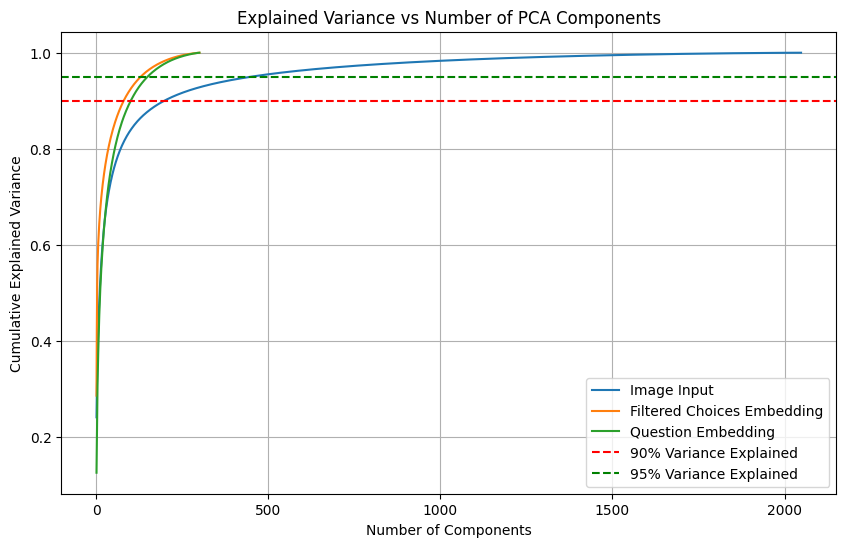

Number of components for 90% variance (Question Embedding): 101
Number of components for 95% variance (Question Embedding): 150
Number of components for 90% variance (Image Input): 199
Number of components for 95% variance (Image Input): 451
Number of components for 90% variance (Filtered Choices): 81
Number of components for 95% variance (Filtered Choices): 130


In [56]:
from sklearn.decomposition import PCA

# Calculate explained variance for image input
pca_image_full = PCA().fit(X_train.iloc[:, :2048].values)
explained_variance_ratio_image = np.cumsum(pca_image_full.explained_variance_ratio_)

# Calculate explained variance for filtered choices embedding
pca_filtered_choices_full = PCA().fit(np.vstack(X_train['filtered_choices_embedding'].values))
explained_variance_ratio_filtered_choices = np.cumsum(pca_filtered_choices_full.explained_variance_ratio_)

# Calculate explained variance for question embedding
pca_question_full = PCA().fit(np.vstack(X_train['question_embedding'].values))
explained_variance_ratio_question = np.cumsum(pca_question_full.explained_variance_ratio_)


# Plot cumulative explained variance for image input
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance_ratio_image) + 1), explained_variance_ratio_image, label='Image Input')
plt.plot(np.arange(1, len(explained_variance_ratio_filtered_choices) + 1), explained_variance_ratio_filtered_choices, label='Filtered Choices Embedding')
plt.plot(np.arange(1, len(explained_variance_ratio_question) + 1), explained_variance_ratio_question, label='Question Embedding')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of PCA Components')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance Explained')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Variance Explained')
plt.legend()
plt.grid(True)
plt.show()

# Determine the number of components for 90% and 95% explained variance
n_components_image_90 = np.argmax(explained_variance_ratio_image >= 0.90) + 1
n_components_image_95 = np.argmax(explained_variance_ratio_image >= 0.95) + 1

n_components_filtered_choices_90 = np.argmax(explained_variance_ratio_filtered_choices >= 0.90) + 1
n_components_filtered_choices_95 = np.argmax(explained_variance_ratio_filtered_choices >= 0.95) + 1

# Determine the number of components for 90% and 95% explained variance
n_components_question_90 = np.argmax(explained_variance_ratio_question >= 0.90) + 1
n_components_question_95 = np.argmax(explained_variance_ratio_question >= 0.95) + 1

print(f"Number of components for 90% variance (Question Embedding): {n_components_question_90}")
print(f"Number of components for 95% variance (Question Embedding): {n_components_question_95}")
print(f"Number of components for 90% variance (Image Input): {n_components_image_90}")
print(f"Number of components for 95% variance (Image Input): {n_components_image_95}")
print(f"Number of components for 90% variance (Filtered Choices): {n_components_filtered_choices_90}")
print(f"Number of components for 95% variance (Filtered Choices): {n_components_filtered_choices_95}")


##### Use the optimal number of features (captures 95% variance) to compute your final PCs

In [68]:
from sklearn.decomposition import PCA

# Define the number of principal components for PCA
n_components_image = 452  # Reduce image input dimensions from 2048 to 452
n_components_filtered_choices = 131  # Reduce filtered_choices_embedding_input from 300 to 131
n_components_questions = 150  # Reduce question_embedding_input from 300 to 150

# Apply PCA to image input
pca_image = PCA(n_components=n_components_image)
image_train_pca = pca_image.fit_transform(X_train.iloc[:, :2048].values)
image_test_pca = pca_image.transform(X_test.iloc[:, :2048].values)
image_valid_pca = pca_image.transform(df_valid.iloc[:, :2048].values)

# Apply PCA to question embedding
pca_questions = PCA(n_components=n_components_questions)
question_train_pca = pca_questions.fit_transform(np.vstack(X_train['question_embedding'].values))
question_test_pca = pca_questions.transform(np.vstack(X_test['question_embedding'].values))
question_valid_pca = pca_questions.transform(np.vstack(df_valid['question_embedding'].values))

# Apply PCA to filtered choices embedding
pca_filtered_choices = PCA(n_components=n_components_filtered_choices)
filtered_choices_train_pca = pca_filtered_choices.fit_transform(np.vstack(X_train['filtered_choices_embedding'].values))
filtered_choices_test_pca = pca_filtered_choices.transform(np.vstack(X_test['filtered_choices_embedding'].values))
filtered_choices_valid_pca = pca_filtered_choices.transform(np.vstack(df_valid['filtered_choices_embedding'].values))

In [69]:
# Function to convert PCA result to DataFrame with preserved index
def pca_to_df(pca_result, df_original, prefix):
    """ Convert PCA results (NumPy array) to Pandas DataFrame and preserve the original DataFrame's index """
    df_pca = pd.DataFrame(pca_result, index=df_original.index,
                          columns=[f'{prefix}_pca_{i}' for i in range(pca_result.shape[1])])
    return df_pca

# Convert the PCA results to DataFrames with preserved row indices
X_image_train_pca = pca_to_df(image_train_pca, X_train, 'image')
X_image_test_pca = pca_to_df(image_test_pca, X_test, 'image')
df_image_valid_pca = pca_to_df(image_valid_pca, df_valid, 'image')

X_filtered_choices_train_pca = pca_to_df(filtered_choices_train_pca, X_train, 'filtered_choices')
X_filtered_choices_test_pca = pca_to_df(filtered_choices_test_pca, X_test, 'filtered_choices')
df_filtered_choices_valid_pca = pca_to_df(filtered_choices_valid_pca, df_valid, 'filtered_choices')

X_questions_train_pca = pca_to_df(question_train_pca, X_train, 'questions')
X_questions_test_pca = pca_to_df(question_test_pca, X_test, 'questions')
df_questions_valid_pca = pca_to_df(question_valid_pca, df_valid, 'questions')

In [70]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,2043,2044,2045,2046,2047,question_embedding,question_type_embedding,filtered_choices_embedding,answer_weight,answer_type_encoded
48572,1.197609,0.046220,0.144112,0.467456,0.077378,1.161129,0.960013,0.418951,0.840909,0.744916,...,0.208375,1.467212,2.758441,0.939148,0.421000,"[0.012756348, -0.041748047, 0.053466797, 0.107...","[0.012756348, -0.041748047, 0.053466797, 0.107...","[0.029622396, -0.108805336, 0.046447754, 0.109...",0.4,1
38696,0.260141,0.141472,0.000000,2.069959,0.018433,1.228132,0.188874,0.138238,4.187469,0.292107,...,0.960892,1.424604,2.235430,1.953497,0.393104,"[0.012329102, 0.20410156, -0.28515625, 0.21679...","[0.012329102, 0.20410156, -0.28515625, 0.21679...","[0.089364626, 0.04080353, -0.0008911133, 0.115...",0.9,2
13611,0.449400,1.057897,0.321751,0.733854,0.012448,1.655118,0.408111,0.259265,0.764723,0.083264,...,0.004595,1.052646,4.507308,2.480709,0.190921,"[0.12547302, -0.07366943, 0.032089233, 0.08081...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.057454426, 0.06429037, 0.039296467, 0.05550...",0.7,2
35213,0.741694,1.308700,0.172705,0.591815,0.070633,0.444096,0.681609,0.305773,0.602083,0.098680,...,0.000000,0.441840,3.833966,0.812568,0.182571,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.065979004, -0.080973305, 0.048746746, 0.116...",1.0,2
31766,1.068136,0.599810,0.445329,0.657603,0.010107,0.551988,0.027920,1.016533,0.072617,0.067725,...,0.311013,0.552151,4.516645,0.506369,0.174714,"[-0.064453125, 0.01763916, -0.008056641, 0.202...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.020589193, -0.013848199, 0.115587026, 0.11...",1.0,2


In [73]:
# Concatenate PCA results with the original `target_answer` column
X_train_pca = pd.concat([X_train[['answer_weight', 'answer_type_encoded']], X_image_train_pca, X_questions_train_pca, X_filtered_choices_train_pca], axis=1)
X_test_pca = pd.concat([X_test[['answer_weight', 'answer_type_encoded']], X_image_test_pca, X_questions_test_pca, X_filtered_choices_test_pca], axis=1)

df_valid_pca = pd.concat([df_valid[['target_answer', 'answer_weight', 'answer_type_encoded']], df_image_valid_pca, df_questions_valid_pca, df_filtered_choices_valid_pca], axis=1)
df_valid_pca.head()

,target_answer,answer_weight,answer_type_encoded,image_pca_0,image_pca_1,image_pca_2,image_pca_3,image_pca_4,image_pca_5,image_pca_6,...,filtered_choices_pca_121,filtered_choices_pca_122,filtered_choices_pca_123,filtered_choices_pca_124,filtered_choices_pca_125,filtered_choices_pca_126,filtered_choices_pca_127,filtered_choices_pca_128,filtered_choices_pca_129,filtered_choices_pca_130
0,no,1.0,2,-17.418636,-8.616139,1.182032,-7.194832,3.033924,-6.518407,-7.064404,...,-0.039759,0.027497,-0.057702,-0.033774,-0.022423,0.003890,0.024489,-0.070453,-0.042553,-0.035593
1,orange,1.0,1,-17.418636,-8.616139,1.182032,-7.194832,3.033924,-6.518407,-7.064404,...,-0.004203,0.010576,0.014258,0.008653,0.020136,0.062389,-0.027812,0.036800,-0.000069,0.004676
2,yes,0.9,2,-17.418636,-8.616139,1.182032,-7.194832,3.033924,-6.518407,-7.064404,...,-0.033128,-0.047092,-0.062820,-0.046975,-0.056763,0.007250,0.001459,-0.041323,-0.001572,-0.040411
3,yes,1.0,2,18.684669,-4.703080,-12.923717,4.448396,2.927459,-6.816647,-2.447950,...,-0.019362,-0.020391,-0.028756,-0.024306,0.025538,-0.055382,0.006084,-0.012002,0.027220,0.019331
4,under tree,0.3,1,18.684669,-4.703080,-12.923717,4.448396,2.927459,-6.816647,-2.447950,...,0.050669,-0.006692,0.017070,-0.016210,0.025298,-0.026018,0.005590,0.060952,0.018628,0.046799


In [74]:
X_train = X_train_pca
X_test = X_test_pca
df_valid = df_valid_pca

##### Save Workspace

In [75]:
joblib.dump(X_train, "/content/drive/MyDrive/Colab Notebooks/894/Training/(3)_dfTrain_2.3.joblib")
joblib.dump(X_test, "/content/drive/MyDrive/Colab Notebooks/894/Training/(3)_dfTest_2.3.joblib")
joblib.dump(df_valid, "/content/drive/MyDrive/Colab Notebooks/894/Validation/(3)_dfValid_2.3.joblib")

# joblib.dump(pca_image, "/content/drive/MyDrive/Colab Notebooks/894/Training/(4)_pca_image_3.2.joblib")
# joblib.dump(pca_questions, "/content/drive/MyDrive/Colab Notebooks/894/Training/(4)_pca_questions_3.2.joblib")
# joblib.dump(pca_answers, "/content/drive/MyDrive/Colab Notebooks/894/Training/(4)_pca_answers_3.2.joblib")
# joblib.dump(pca_filtered_choices, "/content/drive/MyDrive/Colab Notebooks/894/Training/(4)_pca_filtered_choices_3.2.joblib"

['/content/drive/MyDrive/Colab Notebooks/894/Validation/(3)_dfValid_2.3.joblib']

# Step 3: Model Architecture, Training & Hyperparameter Tuning

##### Load Workspace

In [76]:
X_train = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/(3)_dfTrain_2.3.joblib")
X_test = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/(3)_dfTest_2.3.joblib")
df_valid = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/(3)_dfValid_2.3.joblib")

y_train = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/(2)_y_train_2.2.joblib")
y_test = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/(2)_y_test_2.2.joblib")

# df_train = joblib.load("/Users/nila/Library/CloudStorage/GoogleDrive-nilaa.nahar@gmail.com/My Drive/Colab Notebooks/894/Training/(3)_dfTrain_3.1.joblib")
# df_valid = joblib.load("/Users/nila/Library/CloudStorage/GoogleDrive-nilaa.nahar@gmail.com/My Drive/Colab Notebooks/894/Validation/(3)_dfValid_3.1.joblib")

X_train.head()

,answer_weight,answer_type_encoded,image_pca_0,image_pca_1,image_pca_2,image_pca_3,image_pca_4,image_pca_5,image_pca_6,image_pca_7,...,filtered_choices_pca_121,filtered_choices_pca_122,filtered_choices_pca_123,filtered_choices_pca_124,filtered_choices_pca_125,filtered_choices_pca_126,filtered_choices_pca_127,filtered_choices_pca_128,filtered_choices_pca_129,filtered_choices_pca_130
48572,0.4,1,10.607007,-5.834397,5.086226,-3.464539,-16.254009,8.416709,0.784902,6.908187,...,0.008433,0.009024,-0.012766,0.015802,0.014920,0.019590,-0.016536,-0.005820,0.005007,0.016357
38696,0.9,2,-16.158222,-2.634463,0.331538,-3.663011,-0.383804,-2.498765,0.113148,0.728038,...,-0.003105,-0.019008,0.000498,0.006140,0.021174,-0.004823,0.014807,-0.040405,-0.025194,-0.004289
13611,0.7,2,12.570929,10.715144,-1.634211,-2.931629,-1.327492,2.433753,-2.250697,1.636310,...,0.007015,0.033200,0.003995,-0.019217,0.026219,0.064392,-0.026611,0.036575,-0.038668,-0.018599
35213,1.0,2,15.057179,1.024522,-2.650391,1.810597,-2.072258,-4.420029,-4.400763,4.420974,...,0.015284,0.011966,0.018422,0.011659,0.028567,0.015355,-0.017562,-0.018667,-0.009094,-0.004105
31766,1.0,2,20.336374,7.430761,-7.138758,3.603727,-0.365811,-3.376226,-0.723058,4.649781,...,0.039389,0.003953,0.039414,-0.035519,-0.020677,-0.017972,0.011212,0.000989,-0.011991,0.011030


### 3.1 Model Architecture

In [78]:
# Define the number of principal components for PCA
n_components_image = 452
n_components_filtered_choices = 131
n_components_questions = 150
n_components_answers = 134

In [79]:
y_train = pd.DataFrame(y_train, columns=['target_answer'])
y_test = pd.DataFrame(y_test, columns=['target_answer'])

In [ ]:
# Define input layers for PCA-transformed inputs
question_embedding_input = Input(shape=(n_components_questions,), name='question_embedding_input')  # Use PCA components shape
filtered_choices_embedding_input = Input(shape=(n_components_filtered_choices,), name='filtered_choices_embedding_input')  # Use PCA components shape
image_input = Input(shape=(n_components_image,), name='image_input')  # Use PCA components shape

answer_type_input = Input(shape=(1,), name='answer_type_encoded')  # One-dimensional label-encoded feature
combined = Concatenate()([question_embedding_input, image_input,
                          filtered_choices_embedding_input, answer_type_input])

# Create dense layers and dropout layers for the combined inputs
x = Dense(64, activation='relu')(combined)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# One-hot encode the target labels for training and validation
train_labels = pd.get_dummies(y_train['target_answer']).values
test_labels = pd.get_dummies(y_test['target_answer']).values
valid_labels = pd.get_dummies(df_valid['target_answer']).values

# Check that the validation labels have the same number of classes as training labels
if test_labels.shape[1] != train_labels.shape[1]:
    print(f"Mismatch in number of classes: Train Labels: {train_labels.shape[1]}, Test Labels: {test_labels.shape[1]}")
    # Create a new zero-filled array with the same number of columns as train_labels
    new_test_labels = np.zeros((test_labels.shape[0], train_labels.shape[1]))
    # Fill the new array with the original test_labels values where classes exist
    new_test_labels[:, :test_labels.shape[1]] = test_labels  # Copy existing classes
    print(f"Shape of adjusted `test_labels`: {new_test_labels.shape}")
    test_labels = new_test_labels

# Check that the validation labels have the same number of classes as training labels
if valid_labels.shape[1] != train_labels.shape[1]:
    print(f"Mismatch in number of classes: Train Labels: {train_labels.shape[1]}, Validation Labels: {valid_labels.shape[1]}")
    # Create a new zero-filled array with the same number of columns as train_labels
    new_valid_labels = np.zeros((valid_labels.shape[0], train_labels.shape[1]))
    # Fill the new array with the original valid_labels values where classes exist
    new_valid_labels[:, :valid_labels.shape[1]] = valid_labels  # Copy existing classes
    print(f"Shape of adjusted `valid_labels`: {new_valid_labels.shape}")
    valid_labels = new_valid_labels


print(f"Final shape of `train_labels`: {train_labels.shape}")
print(f"Final shape of `test_labels`: {test_labels.shape}")

# Define the number of classes for output
num_classes = train_labels.shape[1]  # Get the correct number of classes from train_labels shape
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=[question_embedding_input, answer_embedding_input, image_input,
                      filtered_choices_embedding_input, answer_type_input, answer_confidence_input], outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0002609), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Mismatch in number of classes: Train Labels: 2521, Test Labels: 2367
Shape of adjusted `test_labels`: (120000, 2521)
Mismatch in number of classes: Train Labels: 2521, Validation Labels: 1568
Shape of adjusted `valid_labels`: (300000, 2521)
Final shape of `train_labels`: (480000, 2521)
Final shape of `test_labels`: (120000, 2521)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ question_embedding_input  │ (None, 150)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ answer_embedding_input    │ (None, 134)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_input (InputLayer)  │ (None, 452)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ filtered_choices_embeddi… │ (None, 131)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ answer_type_encoded       │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ answer_confidence_encoded │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 869)            │              0 │ question_embedding_in… │
│ (Concatenate)             │                        │                │ answer_embedding_inpu… │
│                           │                        │                │ image_input[0][0],     │
│                           │                        │                │ filtered_choices_embe… │
│                           │                        │                │ answer_type_encoded[0… │
│                           │                        │                │ answer_confidence_enc… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 64)             │         55,680 │ concatenate_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 64)             │              0 │ dense_19[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 32)             │          2,080 │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 32)             │              0 │ dense_20[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 2521)           │         83,193 │ dropout_15[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 140,953 (550.60 KB)

 Trainable params: 140,953 (550.60 KB)

 Non-trainable params: 0 (0.00 B)

None


### 3.2 Model Training

In [ ]:

train_inputs = {
    'question_embedding_input': X_train.filter(like='questions_pca').values,  # Select columns with 'questions_pca' in the name
    'answer_embedding_input': X_train.filter(like='answers_pca').values,  # Select columns with 'answers_pca' in the name
    'filtered_choices_embedding_input': X_train.filter(like='filtered_choices_pca').values,  # Select columns with 'filtered_choices_pca' in the name
    'image_input': X_train.filter(like='image_pca').values,  # Select columns with 'image_pca' in the name
    'answer_type_encoded': np.reshape(X_train['answer_type_encoded'].values, (-1, 1)),  # Reshape to (num_samples, 1)
    'answer_confidence_encoded': np.reshape(X_train['answer_confidence_encoded'].values, (-1, 1))  # Reshape to (num_samples, 1)
}

# Apply the same PCA transformation to validation inputs using column filtering
test_inputs = {
    'question_embedding_input': X_test.filter(like='questions_pca').values,  # Select columns with 'questions_pca' in the name
    'answer_embedding_input': X_test.filter(like='answers_pca').values,  # Select columns with 'answers_pca' in the name
    'filtered_choices_embedding_input': X_test.filter(like='filtered_choices_pca').values,  # Select columns with 'filtered_choices_pca' in the name
    'image_input': X_test.filter(like='image_pca').values,  # Select columns with 'image_pca' in the name
    'answer_type_encoded': np.reshape(X_test['answer_type_encoded'].values, (-1, 1)),  # Reshape to (num_samples, 1)
    'answer_confidence_encoded': np.reshape(X_test['answer_confidence_encoded'].values, (-1, 1))  # Reshape to (num_samples, 1)
}

# Pass test_inputs instead of X_test to validation_data
history = model.fit(train_inputs, train_labels, validation_data=(test_inputs, test_labels), epochs=10, batch_size=16)

##### Saving the model

In [ ]:
# Save the trained model to a file
model.save('/content/drive/MyDrive/Colab Notebooks/894/Training/(4)_SimpleModel_3.2.h5')

In [ ]:
# Save the history to a text file
with open('/content/drive/MyDrive/Colab Notebooks/894/Training/(4)_SimpleModel_3.2_training_history.txt', 'w') as f:
    f.write("Training and Validation Performance:\n")
    for key, values in history.history.items():
        f.write(f"{key}: {values}\n")


### 3.3. Hyperparameter Tuning (Optuna)

##### Load Workspace


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/894/Training/(4)_SimpleModel_3.2.h5')

X_train = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/(3)_dfTrain_2.3.joblib")
X_test = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/(3)_dfTest_2.3.joblib")
df_valid = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/(3)_dfValid_2.3.joblib")

X_train.head()

,answer_type_encoded,answer_confidence_encoded,image_pca_0,image_pca_1,image_pca_2,image_pca_3,image_pca_4,image_pca_5,image_pca_6,image_pca_7,...,filtered_choices_pca_121,filtered_choices_pca_122,filtered_choices_pca_123,filtered_choices_pca_124,filtered_choices_pca_125,filtered_choices_pca_126,filtered_choices_pca_127,filtered_choices_pca_128,filtered_choices_pca_129,filtered_choices_pca_130
501294,2,2,16.489111,9.330824,-6.624599,4.005575,6.315690,1.753052,-1.787329,2.565279,...,-0.001839,-0.027926,0.016249,-0.035862,0.016563,0.061366,0.031422,-0.029060,0.009067,-0.022341
285039,1,2,15.782750,5.257832,9.884619,5.735088,-3.777805,0.077874,-4.955655,-2.261273,...,0.017134,0.008794,-0.014056,-0.007699,-0.018616,0.021088,0.023476,0.000640,-0.008871,-0.008088
47556,0,2,9.355142,9.582331,-8.721834,-5.331518,5.077461,2.465799,1.553570,-3.628227,...,-0.044030,-0.070415,0.008828,-0.004974,-0.032283,0.040445,0.039304,-0.023819,-0.006596,-0.062314
580653,1,2,-16.833385,-10.600573,-6.992249,3.049653,-4.853133,-0.285765,3.902692,-1.607834,...,-0.015489,0.056286,-0.046613,-0.005485,-0.021657,-0.029898,0.004239,-0.009281,-0.037525,0.060830
547794,2,2,6.558424,-0.330755,2.429197,-8.255101,-3.066995,-2.186913,4.917536,-0.285468,...,-0.004729,0.026347,-0.018563,-0.005191,-0.030277,0.044566,0.012090,-0.023508,-0.018680,-0.025768


In [ ]:
# Define the number of principal components for PCA
n_components_image = 452
n_components_filtered_choices = 131
n_components_questions = 150
n_components_answers = 134

In [ ]:
train_inputs = {
    'question_embedding_input': X_train.filter(like='questions_pca').values,  # Select columns with 'questions_pca' in the name
    'answer_embedding_input': X_train.filter(like='answers_pca').values,  # Select columns with 'answers_pca' in the name
    'filtered_choices_embedding_input': X_train.filter(like='filtered_choices_pca').values,  # Select columns with 'filtered_choices_pca' in the name
    'image_input': X_train.filter(like='image_pca').values,  # Select columns with 'image_pca' in the name
    'answer_type_encoded': np.reshape(X_train['answer_type_encoded'].values, (-1, 1)),  # Reshape to (num_samples, 1)
    'answer_confidence_encoded': np.reshape(X_train['answer_confidence_encoded'].values, (-1, 1))  # Reshape to (num_samples, 1)
}

# Apply the same PCA transformation to validation inputs using column filtering
test_inputs = {
    'question_embedding_input': X_test.filter(like='questions_pca').values,  # Select columns with 'questions_pca' in the name
    'answer_embedding_input': X_test.filter(like='answers_pca').values,  # Select columns with 'answers_pca' in the name
    'filtered_choices_embedding_input': X_test.filter(like='filtered_choices_pca').values,  # Select columns with 'filtered_choices_pca' in the name
    'image_input': X_test.filter(like='image_pca').values,  # Select columns with 'image_pca' in the name
    'answer_type_encoded': np.reshape(X_test['answer_type_encoded'].values, (-1, 1)),  # Reshape to (num_samples, 1)
    'answer_confidence_encoded': np.reshape(X_test['answer_confidence_encoded'].values, (-1, 1))  # Reshape to (num_samples, 1)
}

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    n_units_layer1 = trial.suggest_int('n_units_layer1', 64, 128)  # Number of units in first Dense layer
    n_units_layer2 = trial.suggest_int('n_units_layer2', 16, 32)   # Number of units in second Dense layer
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)   # Dropout rate
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)  # Learning rate for Adam optimizer

    # Define the model architecture (similar to your previous one)
    question_embedding_input = Input(shape=(n_components_questions,), name='question_embedding_input')
    answer_embedding_input = Input(shape=(n_components_answers,), name='answer_embedding_input')
    filtered_choices_embedding_input = Input(shape=(n_components_filtered_choices,), name='filtered_choices_embedding_input')
    image_input = Input(shape=(n_components_image,), name='image_input')

    answer_type_input = Input(shape=(1,), name='answer_type_encoded')  # One-dimensional label-encoded feature
    answer_confidence_input = Input(shape=(1,), name='answer_confidence_encoded')  # One-dimensional label-encoded feature

    # Step 3: Concatenate all inputs
    combined = Concatenate()([question_embedding_input, answer_embedding_input, image_input,
                              filtered_choices_embedding_input, answer_type_input, answer_confidence_input])


    # Fully connected layers with dynamic units and dropout
    x = Dense(n_units_layer1, activation='relu')(combined)
    x = Dropout(dropout_rate)(x)
    x = Dense(n_units_layer2, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    # One-hot encode the target labels for training and validation
    train_labels = pd.get_dummies(y_train['target_answer']).values
    test_labels = pd.get_dummies(y_test['target_answer']).values

    # Check that the validation labels have the same number of classes as training labels
    if test_labels.shape[1] != train_labels.shape[1]:
        print(f"Mismatch in number of classes: Train Labels: {train_labels.shape[1]}, Test Labels: {test_labels.shape[1]}")
        # Create a new zero-filled array with the same number of columns as train_labels
        new_test_labels = np.zeros((test_labels.shape[0], train_labels.shape[1]))
        # Fill the new array with the original test_labels values where classes exist
        new_test_labels[:, :test_labels.shape[1]] = test_labels  # Copy existing classes
        print(f"Shape of adjusted `test_labels`: {new_test_labels.shape}")
        test_labels = new_test_labels

    print(f"Final shape of `train_labels`: {train_labels.shape}")
    print(f"Final shape of `test_labels`: {test_labels.shape}")

    # Define the number of classes for output
    num_classes = train_labels.shape[1]  # Get the correct number of classes from train_labels shape
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[question_embedding_input, answer_embedding_input, image_input,
                          filtered_choices_embedding_input, answer_type_input, answer_confidence_input], outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model with early stopping to prevent overfitting
    model.fit(train_inputs, train_labels, validation_data=(test_inputs, test_labels), epochs=10, batch_size=16)

    # Evaluate the model on validation data
    test_loss, test_accuracy = model.evaluate(test_inputs, test_labels, verbose=0)

    # Return the validation accuracy as the objective value
    return test_accuracy

# Create the study object
study = optuna.create_study(direction='maximize')

# Start optimization
study.optimize(objective, n_trials=20)  # Number of trials can be adjusted

### Final Model Fit

##### Load Workspace

In [ ]:
X_train = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/(3)_dfTrain_2.3.joblib")
X_test = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/(3)_dfTest_2.3.joblib")
df_valid = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/(3)_dfValid_2.3.joblib")

y_train = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/(2)_y_train_2.2.joblib")
y_test = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/(2)_y_test_2.2.joblib")
X_train.head()

,answer_type_encoded,answer_confidence_encoded,image_pca_0,image_pca_1,image_pca_2,image_pca_3,image_pca_4,image_pca_5,image_pca_6,image_pca_7,...,filtered_choices_pca_121,filtered_choices_pca_122,filtered_choices_pca_123,filtered_choices_pca_124,filtered_choices_pca_125,filtered_choices_pca_126,filtered_choices_pca_127,filtered_choices_pca_128,filtered_choices_pca_129,filtered_choices_pca_130
501294,2,2,16.489111,9.330824,-6.624599,4.005575,6.315690,1.753052,-1.787329,2.565279,...,-0.001839,-0.027926,0.016249,-0.035862,0.016563,0.061366,0.031422,-0.029060,0.009067,-0.022341
285039,1,2,15.782750,5.257832,9.884619,5.735088,-3.777805,0.077874,-4.955655,-2.261273,...,0.017134,0.008794,-0.014056,-0.007699,-0.018616,0.021088,0.023476,0.000640,-0.008871,-0.008088
47556,0,2,9.355142,9.582331,-8.721834,-5.331518,5.077461,2.465799,1.553570,-3.628227,...,-0.044030,-0.070415,0.008828,-0.004974,-0.032283,0.040445,0.039304,-0.023819,-0.006596,-0.062314
580653,1,2,-16.833385,-10.600573,-6.992249,3.049653,-4.853133,-0.285765,3.902692,-1.607834,...,-0.015489,0.056286,-0.046613,-0.005485,-0.021657,-0.029898,0.004239,-0.009281,-0.037525,0.060830
547794,2,2,6.558424,-0.330755,2.429197,-8.255101,-3.066995,-2.186913,4.917536,-0.285468,...,-0.004729,0.026347,-0.018563,-0.005191,-0.030277,0.044566,0.012090,-0.023508,-0.018680,-0.025768


In [ ]:
# Trial 13 finished with value: 0.06207500025629997 and parameters: {'n_units_layer1': 110, 'n_units_layer2': 28, 'dropout_rate': 0.25084699879757766, 'learning_rate': 0.00023407630784364424}. Best is trial 13 with value: 0.06207500025629997.

# Manually set the best hyperparameters
best_params = {
    'n_units_layer1': 110,
    'n_units_layer2': 28,
    'dropout_rate': 0.25084699879757766,
    'learning_rate': 0.00023407630784364424,
    'batch_size': 32 # tuned manually
}

# Define the number of principal components for PCA
n_components_image = 452
n_components_filtered_choices = 131
n_components_questions = 150
n_components_answers = 134

y_train = pd.DataFrame(y_train, columns=['target_answer'])
y_test = pd.DataFrame(y_test, columns=['target_answer'])

In [ ]:
# Define input layers for PCA-transformed inputs
question_embedding_input = Input(shape=(n_components_questions,), name='question_embedding_input')  # Use PCA components shape
answer_embedding_input = Input(shape=(n_components_answers,), name='answer_embedding_input')  # Use PCA components shape
filtered_choices_embedding_input = Input(shape=(n_components_filtered_choices,), name='filtered_choices_embedding_input')  # Use PCA components shape
image_input = Input(shape=(n_components_image,), name='image_input')  # Use PCA components shape

answer_type_input = Input(shape=(1,), name='answer_type_encoded')  # One-dimensional label-encoded feature
answer_confidence_input = Input(shape=(1,), name='answer_confidence_encoded')  # One-dimensional label-encoded feature

combined = Concatenate()([question_embedding_input, answer_embedding_input, image_input,
                          filtered_choices_embedding_input, answer_type_input, answer_confidence_input])

# Create dense layers and dropout layers for the combined inputs
x = Dense(64, activation='relu')(combined)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# One-hot encode the target labels for training and validation
train_labels = pd.get_dummies(y_train['target_answer']).values
test_labels = pd.get_dummies(y_test['target_answer']).values
valid_labels = pd.get_dummies(df_valid['target_answer']).values

# Check that the validation labels have the same number of classes as training labels
if test_labels.shape[1] != train_labels.shape[1]:
    print(f"Mismatch in number of classes: Train Labels: {train_labels.shape[1]}, Test Labels: {test_labels.shape[1]}")
    # Create a new zero-filled array with the same number of columns as train_labels
    new_test_labels = np.zeros((test_labels.shape[0], train_labels.shape[1]))
    # Fill the new array with the original test_labels values where classes exist
    new_test_labels[:, :test_labels.shape[1]] = test_labels  # Copy existing classes
    print(f"Shape of adjusted `test_labels`: {new_test_labels.shape}")
    test_labels = new_test_labels

# Check that the validation labels have the same number of classes as training labels
if valid_labels.shape[1] != train_labels.shape[1]:
    print(f"Mismatch in number of classes: Train Labels: {train_labels.shape[1]}, Validation Labels: {valid_labels.shape[1]}")
    # Create a new zero-filled array with the same number of columns as train_labels
    new_valid_labels = np.zeros((valid_labels.shape[0], train_labels.shape[1]))
    # Fill the new array with the original valid_labels values where classes exist
    new_valid_labels[:, :valid_labels.shape[1]] = valid_labels  # Copy existing classes
    print(f"Shape of adjusted `valid_labels`: {new_valid_labels.shape}")
    valid_labels = new_valid_labels


print(f"Final shape of `train_labels`: {train_labels.shape}")
print(f"Final shape of `test_labels`: {test_labels.shape}")

# Define the number of classes for output
num_classes = train_labels.shape[1]  # Get the correct number of classes from train_labels shape
output = Dense(num_classes, activation='softmax')(x)

# Compile the model with the best learning rate
final_model = Model(inputs=[question_embedding_input, answer_embedding_input, image_input,
                      filtered_choices_embedding_input, answer_type_input, answer_confidence_input], outputs=output)

final_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
              loss='categorical_crossentropy', metrics=['accuracy'])

print(final_model.summary())

Mismatch in number of classes: Train Labels: 2521, Test Labels: 2367
Shape of adjusted `test_labels`: (120000, 2521)
Mismatch in number of classes: Train Labels: 2521, Validation Labels: 1568
Shape of adjusted `valid_labels`: (300000, 2521)
Final shape of `train_labels`: (480000, 2521)
Final shape of `test_labels`: (120000, 2521)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ question_embedding_input  │ (None, 150)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ answer_embedding_input    │ (None, 134)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_input (InputLayer)  │ (None, 452)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ filtered_choices_embeddi… │ (None, 131)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ answer_type_encoded       │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ answer_confidence_encoded │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 869)            │              0 │ question_embedding_in… │
│ (Concatenate)             │                        │                │ answer_embedding_inpu… │
│                           │                        │                │ image_input[0][0],     │
│                           │                        │                │ filtered_choices_embe… │
│                           │                        │                │ answer_type_encoded[0… │
│                           │                        │                │ answer_confidence_enc… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 64)             │         55,680 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 64)             │              0 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 32)             │          2,080 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 32)             │              0 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 2521)           │         83,193 │ dropout_9[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 140,953 (550.60 KB)

 Trainable params: 140,953 (550.60 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
train_inputs = {
    'question_embedding_input': X_train.filter(like='questions_pca').values,  # Select columns with 'questions_pca' in the name
    'answer_embedding_input': X_train.filter(like='answers_pca').values,  # Select columns with 'answers_pca' in the name
    'filtered_choices_embedding_input': X_train.filter(like='filtered_choices_pca').values,  # Select columns with 'filtered_choices_pca' in the name
    'image_input': X_train.filter(like='image_pca').values,  # Select columns with 'image_pca' in the name
    'answer_type_encoded': np.reshape(X_train['answer_type_encoded'].values, (-1, 1)),  # Reshape to (num_samples, 1)
    'answer_confidence_encoded': np.reshape(X_train['answer_confidence_encoded'].values, (-1, 1))  # Reshape to (num_samples, 1)
}

# Apply the same PCA transformation to validation inputs using column filtering
test_inputs = {
    'question_embedding_input': X_test.filter(like='questions_pca').values,  # Select columns with 'questions_pca' in the name
    'answer_embedding_input': X_test.filter(like='answers_pca').values,  # Select columns with 'answers_pca' in the name
    'filtered_choices_embedding_input': X_test.filter(like='filtered_choices_pca').values,  # Select columns with 'filtered_choices_pca' in the name
    'image_input': X_test.filter(like='image_pca').values,  # Select columns with 'image_pca' in the name
    'answer_type_encoded': np.reshape(X_test['answer_type_encoded'].values, (-1, 1)),  # Reshape to (num_samples, 1)
    'answer_confidence_encoded': np.reshape(X_test['answer_confidence_encoded'].values, (-1, 1))  # Reshape to (num_samples, 1)
}

In [ ]:
history = final_model.fit(train_inputs, train_labels, validation_data=(test_inputs, test_labels), epochs=10, batch_size=best_params['batch_size'])

Epoch 1/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 0.6764 - loss: 1.3487 - val_accuracy: 0.0590 - val_loss: 97.3765
Epoch 2/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 0.6786 - loss: 1.3373 - val_accuracy: 0.0590 - val_loss: 99.3265
Epoch 3/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.6779 - loss: 1.3387 - val_accuracy: 0.0591 - val_loss: 100.5343
Epoch 4/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.6795 - loss: 1.3286 - val_accuracy: 0.0591 - val_loss: 104.5560
Epoch 5/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.6795 - loss: 1.3216 - val_accuracy: 0.0591 - val_loss: 106.0147
Epoch 6/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 0.6803 - loss: 1.3159 - val_accuracy: 0.0593 - val_loss: 109.6941
Epoch 7/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.6826 - loss: 1.3080 - val_accuracy: 0.0592 - val_loss: 110.2353
Epoch 8/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step 

In [ ]:
# Save the trained model to a file
final_model.save('/content/drive/MyDrive/Colab Notebooks/894/Training/(5)_FinalModel_4.0.h5')

In [ ]:
del df_train, df_valid
del question_embedding_input, answer_embedding_input, image_input, filtered_choices_embedding_input, answer_type_input, answer_confidence_input, combined, x, output
del train_inputs, valid_inputs, train_labels, valid_labels
del n_components_image, n_components_filtered_choices, n_components_questions, n_components_answers
del best_params, new_valid_labels, num_classes, study, stopwords

### Final Model's Accuracy: 0.665 on Validation Set


---




---



---



# Step 5: Testing & Performance (Not Applicable)

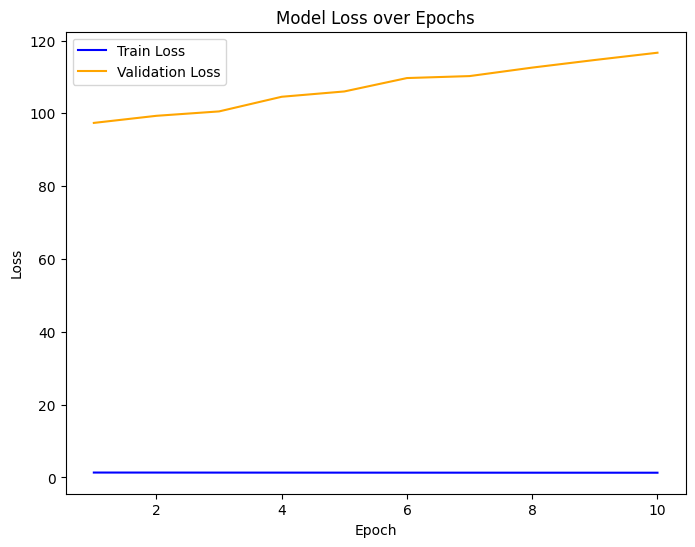

In [ ]:
# Access the loss values from the history object
train_loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Plotting loss over epochs
plt.figure(figsize=(8, 6))
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()